# Prepare some figures for the 2018 NSF/CDS&E proposal

In [1]:
import os, time
import numpy as np

In [7]:
import fsps
import sedpy
import prospect

/usr/local/anaconda3/envs/LSLGA/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
%matplotlib inline

In [5]:
phot = dict(
    FUV=(1528.0597, 18.7742346978),
    NUV=(2271.1257, 18.2877269035),
    g=(4771.4883, 15.2561267845),
    r=(6391.7354, 14.5113609983),
    z=(9149.0635, 13.8846830596),
    W1=(33461.023, 14.2520410312),
    W2=(45952.086, 14.7917564957),
    W3=(115531.34, 13.597660877),
    W4=(220781.86, 13.1456577726))

In [8]:
verbose = True
zcontinuous = 1

### Data

In [22]:
def load_obs(snr=10):
    """Assume 10% errors."""
    from prospect.utils.obsutils import fix_obs    
    
    galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['wise_w'+n for n in ['1','2','3','4']]
    sdss = ['sdss_{0}0'.format(b) for b in ['g', 'r', 'z']]
    filternames = galex + sdss + spitzer

    obs = {}
    obs['redshift'] = 0.03302
    obs["filters"] = sedpy.observate.load_filters(filternames)

    mags = np.array([phot[filt][1] for filt in phot.keys()])
    obs["maggies"] = 10**(-0.4*mags)
    obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # mask out W4
    #obs["phot_mask"] = np.array(['w4' in f.name for f in obs["filters"]])    
    
    # we will also create a handy vector of effective wavelengths, though this is not required
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]
    obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
    obs["spectrum"] = None
    obs['unc'] = None  #spectral uncertainties are given here
    obs['mask'] = None
    obs = fix_obs(obs)
    return obs

In [23]:
obs = load_obs()

In [12]:
run_params = {}
run_params['redshift'] = obs['redshift']
run_params["snr"] = 10.0
run_params["zcontinuous"] = zcontinuous
run_params["verbose"] = verbose

### Model

In [13]:
def load_model(obs):
    
    from prospect.models import priors
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary["parametric_sfh"]
    
    # fixed redshift
    model_params["zred"]['isfree'] = False
    model_params["zred"]['init'] = obs['redshift']
        
    # fixed metallicity
    model_params["logzsol"]["isfree"] = False
    model_params["logzsol"]['init'] = 0.019
       
    # Adjust model initial values
    model_params["dust2"]["init"] = 0.0
    model_params["tage"]["init"] = 10.
    model_params["mass"]["init"] = 1e10
    
    # adjust priors
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e9, maxi=1e12)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e7
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Add dust emission (with fixed dust SED parameters)
    model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model using this new dictionary of parameter specifications
    model = SedModel(model_params)

    return model

In [17]:
model = load_model(obs)

In [14]:
def load_sps(zcontinuous=1):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

In [15]:
def lnprobfn(theta, nested=False, verbose=verbose):
    """
    Given a parameter vector, a dictionary of observational data 
    a model object, and an sps object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.

    """
    from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    t1 = time.time()
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
    d1 = time.time() - t1
 
    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

In [18]:
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    
    """
    from prospect.likelihood import chi_spec, chi_phot
    
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty

    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

In [19]:
%time sps = load_sps(zcontinuous=zcontinuous)

CPU times: user 11.1 s, sys: 932 ms, total: 12 s
Wall time: 12.2 s


### Simple maximum-likelihood fitting

In [20]:
from prospect import fitting
from scipy.optimize import least_squares
run_params["nmin"] = 5
run_params['ftol'] = 3e-16 
run_params['maxfev'] = 5000
run_params['xtol'] = 3e-16

In [24]:
# --- start minimization ----
min_method = 'levenberg_marquardt'
run_params["min_method"] = min_method

# We'll start minimization from "nmin" separate places, 
# the first based on the "init" values of each parameter and the 
# rest drawn from the prior.  This can guard against local minima.
nmin = run_params["nmin"]
ts = time.time()  # time it
pinitial = fitting.minimizer_ball(model.initial_theta.copy(), nmin, model)
guesses = []
for i, pinit in enumerate(pinitial): #loop over initial guesses
    res = least_squares(chivecfn, np.array(pinit), method='lm', x_scale='jac',
                        xtol=run_params["xtol"], ftol=run_params["ftol"], 
                        max_nfev=run_params["maxfev"])
    guesses.append(res)

# Calculate chi-square of the results, and choose the best one
# fitting.reinitialize moves the parameter vector away from edges of the prior.
chisq = [np.sum(r.fun**2) for r in guesses]
best = np.argmin(chisq)
theta_best = fitting.reinitialize(guesses[best].x, model,
                                  edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = None
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} chi-sq: {1}'.format(min_method, chisq[best]))
print('best guess paramaters:')
for k, t in zip(model.theta_labels(), theta_best):
    print('  {} = {}'.format(k, t))

/usr/local/anaconda3/envs/LSLGA/lib/python3.6/site-packages/prospect-0.2-py3.6.egg/prospect/models/priors.py:155: RuntimeWarning: divide by zero encountered in log


done levenberg_marquardt in 4.255380153656006s
best levenberg_marquardt chi-sq: 19.517384420752933
best guess paramaters:
  mass = 42743625560.20938
  dust2 = 0.4448133922800307
  tage = 2.534352073852554
  tau = 0.3517230506892688


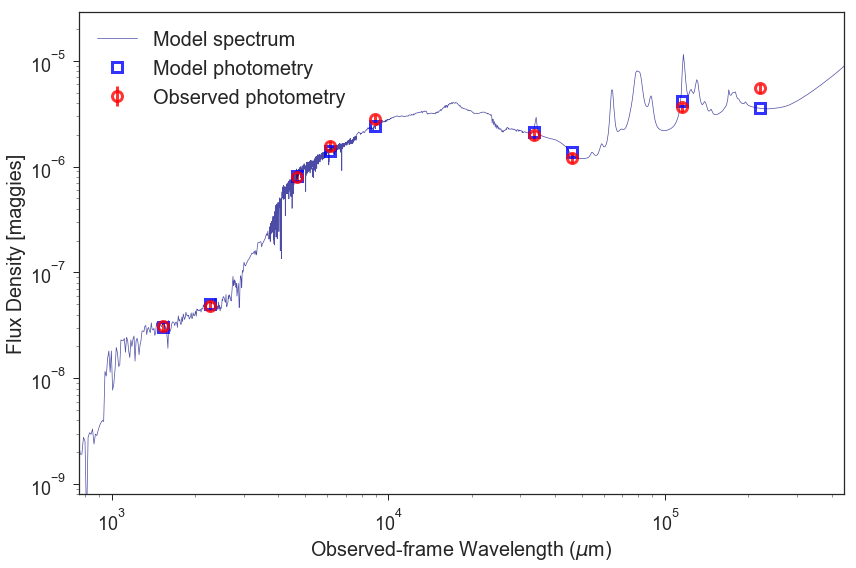

In [25]:
# generate model
from matplotlib.pylab import *
prediction = model.mean_model(theta_best, obs, sps=sps)
pspec, pphot, pextra = prediction

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]

if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.5, np.max(wphot)/0.5
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, pspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4    
    
figure(figsize=(12, 8))

loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
#for f in obs['filters']:
#    w, t = f.wavelength.copy(), f.transmission.copy()
#    while t.max() > 1:
#        t /= 10.
#    t = 0.1*(ymax-ymin)*t + ymin
#    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel(r'Observed-frame Wavelength ($\mu$m)')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [30]:
np.savetxt('sed.txt', np.array([wspec, pspec]).T)

In [31]:
wspec

array([9.40048200e+01, 9.71038800e+01, 9.91699200e+01, ...,
       1.01411573e+08, 1.02351622e+08, 1.03302000e+08])